###Import Data

In [2]:
#import data into google colab
from google.colab import files
uploaded = files.upload()
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving raw_data.csv to raw_data.csv
User uploaded file "raw_data.csv" with length 230408 bytes


In [48]:
#import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

data=pd.read_csv('raw_data.csv',header=0,parse_dates=True,infer_datetime_format=True)

In [6]:
data.head()

,order_id,shop_id,user_id,order_amount,total_items,payment_method,created_at
0,1,53,746,224,2,cash,2017-03-13 12:36:56
1,2,92,925,90,1,cash,2017-03-03 17:38:52
2,3,44,861,144,1,cash,2017-03-14 4:23:56
3,4,18,935,156,1,credit_card,2017-03-26 12:43:37
4,5,18,883,156,1,credit_card,2017-03-01 4:35:11


###Question 1
There are potential ***problematic/invalid*** transactions. To calculate AOV, these invalid transaction should be excluded. In this analysis, a transaction is classified as ***problematic/invalid*** if one of the following criteria are met

1.   Total items per order is > 20
2.   Unit Price for each item sold >$500.00 (In practice, this limit could be eased based on product/store types, so luxary products could be considered.)

Potential criteria(not used in this analysis)
4.   Bad shop which involves a certain number of invalid transactions
5.   Rain checks/consecutive check out
6.   All transaction made by bad buyers (only 607 is bad buyer in this dataset)

In [51]:
#setting criteria threshold of invalid transaction
max_item=20
max_unit_price=500
# data['validity']=1 #set initial default value as valid(1)

In [52]:
# criteria 1: mark total_item per order > 20 as invalid transaction
data['order_validity']=data['total_items'].apply(lambda x: 0 if x>max_item else 1)


In [53]:
# criteria 2: mark unit price greater than $500 as invalid transaction
data['price_validity']=data.apply(lambda row: 0 if (row.order_amount/row.total_items)>max_unit_price else 1, axis=1)


In [54]:
data['validity']=[data['order_validity'][i] and data['price_validity'][i] for i in range(data.shape[0])]
print('The number of invalid transactions is: ',data.validity.value_counts()[0])

The number of invalid transactions is:  63


###Metrics to report
Valid Transaction


> *   Part1: Financial Metrics
>>1. Total item sold and total transaction during the period
>>2. Average price of a pair of shoes
>>3. Seasonality

> *   Part2: Shop Metrics
>>1. Active shop
>>2. Ranking by total sales amount(most profitable shop)

> *   Part3: User Metrics
>>1. Active user
>>2. Payment method analysis
>>3. Shopping time analysis


Invalid Transaction
1. Total sales amount and number of invalid transations
2. Number and percentaqge of invalid transactions
3. Summary and statistics about bad buyers and bad shop information








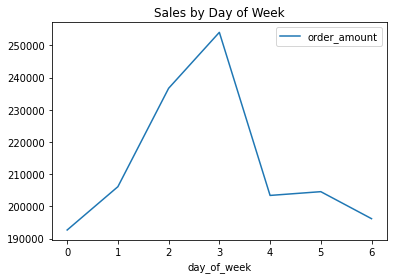

total_item_sold:  9848
total_sales:  1493840


In [85]:
#Part1 metrics
#Seasonality
data.created_at=pd.to_datetime(data.created_at,format='%Y-%m-%d %H:%M:%S') #format str into datetime
data['day_of_week']=data.created_at.dt.dayofweek
filtered_data=data[data.validity==1]
filtered_data

weekly_trend=filtered_data.groupby(by=['day_of_week']).agg({'order_amount':['sum']})
weekly_trend.columns=weekly_trend.columns.droplevel(level=[1])
weekly_trend.reset_index(inplace=True)
weekly_trend.plot(x='day_of_week',y='order_amount')
plt.title('Sales by Day of Week')
plt.show()


#Financial
total_item_sold=filtered_data.total_items.sum()
total_sales=filtered_data.order_amount.sum()

print('total_item_sold: ',total_item_sold)
print('total_sales: ',total_sales)

Part1 Conclusion: There are 9848 pairs of shoes sold in the period with total sales around 1.5 million dollars. 
From the weekly sales plot, the sales reached a peak on Thursday, and plunged over the weekend.

In [103]:
#Part2 metrics
print('# of active shops: ', len(set(filtered_data.shop_id)))

sales_ranking=filtered_data.groupby(by=['shop_id']).agg({'order_amount':'sum'})
sales_ranking=sales_ranking.sort_values(by='order_amount',ascending=False)
top_10_shop=sales_ranking[:10]
top_10_shop

max_sale, max_shop=sales_ranking.values[0],sales_ranking.index[0]
min_sale,min_shop=sales_ranking.values[-1],sales_ranking.index[-1]
print("Shop_ID {} has the biggest sales at ${}".format(max_shop, max_sale[0]))
print("Shop_ID {} has the lowest sales at ${}".format(min_shop, min_sale[0]))



# of active shops:  99
Shop_ID 89 has the biggest sales at $23128
Shop_ID 92 has the lowest sales at $6840


In [148]:
#Part3 metrics

#number of active users
active_user=len(filtered_data.user_id.unique())

#payment methods analysis
print('Payment methods:', set(filtered_data.payment_method))
payment_chart=filtered_data.groupby(by=['payment_method']).agg({'order_amount':['sum','count']})
print(payment_chart)

#percentage calculation
amount=payment_chart['order_amount']['sum']
amount_in_percent=["{0:.2f}%".format(val*100) for val in amount/amount.sum()]
dic={'amount':amount.values,'amount in %':amount_in_percent}
payment_summary=pd.DataFrame(data=dic,index=payment_chart.index)
print(payment_summary)

Payment methods: {'debit', 'credit_card', 'cash'}
               order_amount      
                        sum count
payment_method                   
cash                 469608  1576
credit_card          514817  1708
debit                509415  1653
                amount amount in %
payment_method                    
cash            469608      31.44%
credit_card     514817      34.46%
debit           509415      34.10%


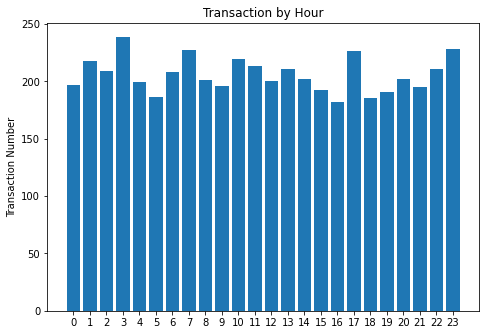

In [178]:
#shopping time analysis
data['created_at_hour']=data['created_at'].dt.hour
filtered_data=data[data.validity==1]
shopping_time_table=filtered_data.groupby(by='created_at_hour').agg({'user_id':['count']})

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
hr=[x for x in range(24)]
user_number=shopping_time_table['user_id']['count'].values
ax.bar(hr,user_number)
ax.set_ylabel('Transaction Number')
ax.set_title('Transaction by Hour')
ax.set_xticks(hr)
plt.show()

Part3 Conclusion: 
There are 3 kinds of payment methods(cash, credit, debit). Payment methods are evenly distributed where each takes more than 30% . 
No obvious pattern is found on shopping time. Transactions are roughly throught out 24 hours uniformly.

In [181]:
# Invalid transaction
invalid_transaction=data[data.validity==0]
invalid_number=invalid_transaction.shape[0]
invalid_amount=invalid_transaction.order_amount.sum()
print('There are {} transactions classified at invalid, total transaction amount involved is ${}'.format(invalid_number, invalid_amount))

# collect bad shop and bad buyer into shop_watch_list and user_watch_list
shop_watch_list=invalid_transaction.shop_id.unique()
user_watch_list=invalid_transaction.user_id.unique()
print('shop_watch_list:', shop_watch_list)
print('user_watch_list:', user_watch_list)

There are 63 transactions classified at invalid, total transaction amount involved is $14231800
shop_watch_list: [42 78]
user_watch_list: [607 990 936 983 967 760 878 800 944 970 775 867 912 812 810 855 709 834
 707 935 861 915 962 890 869 814 817 740 910 745 927 928 982 828 766 889
 852 946 787 960 756 969 866 997 818 823]


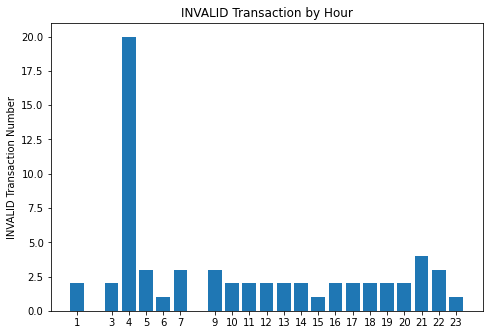

In [194]:
#invalid transaction by time
shopping_time_invalid=invalid_transaction.groupby(by='created_at_hour').agg({'user_id':['count']})
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
hr=shopping_time_invalid.index
user_number=shopping_time_table['user_id']['count'].values
ax.bar(hr, user_number)
ax.set_ylabel('INVALID Transaction Number')
ax.set_title('INVALID Transaction by Hour')
ax.set_xticks(hr)
plt.show()

In [202]:
#a closer look at invalid transaction around 4am
print('involved users(4 a.m.)')
print(invalid_transaction[invalid_transaction.created_at_hour==4].user_id.value_counts())

print(" ")
print('involved shops(4 a.m.)')
print(invalid_transaction[invalid_transaction.created_at_hour==4].shop_id.value_counts())

involved users(4 a.m.)
607    17
756     1
707     1
834     1
Name: user_id, dtype: int64
 
involved shops(4 a.m.)
42    17
78     3
Name: shop_id, dtype: int64


There are total 63 invalid transactions; the majority(20 cases) happend at around 4 A.M.
With a closer look at cases around 4 A.M. , these invalid transactions are mostly created by user_id 17 and shop_id 42.

###Question1C The AOV value

In [209]:
filtered_data.order_amount.mean()

302.58051448247926

###Question2 SQL Code and Answers

In [ ]:
1. ANSWER: 54

SELECT COUNT(O.OrderID)
FROM Orders AS O
LEFT JOIN Shippers AS S
ON O.ShipperID=S.ShipperID
WHERE S.ShipperName="Speedy Express";

In [ ]:
2 ANSWER: Peacock

WITH top_one AS (SELECT EmployeeID, COUNT(EmployeeID) AS order_count
FROM Orders
GROUP BY EmployeeID
ORDER BY order_count DESC
LIMIT 1)
SELECT LastName
FROM top_one
LEFT JOIN Employees AS E
ON top_one.EmployeeID=E.EmployeeID;


In [ ]:
3. ANSWER: Boston Crab Meat

SELECT Products.ProductName
FROM

(
SELECT OD.ProductID, SUM(OD.Quantity) AS subtotal
FROM OrderDetails AS OD
WHERE OD.OrderID IN
(SELECT O.OrderID 
FROM Customers AS C
JOIN Orders AS O
ON C.CustomerID=O.CustomerID
WHERE Country='Germany')
GROUP BY OD.ProductID
ORDER BY subtotal DESC
LIMIT 1
) AS top_sale_product

JOIN Products
ON top_sale_product.ProductID=Products.ProductID;